# Техническая часть

In [1]:
!pip install -q sentencepiece
import sentencepiece
!pip install -q transformers

!pip install -q torchmetrics
!pip install -q comet_ml
import comet_ml
!pip install -q pytorch-lightning

!git clone -q https://github.com/DanilDmitriev1999/QA

     |████████████████████████████████| 1.2MB 7.1MB/s 
     |████████████████████████████████| 2.1MB 8.5MB/s 
     |████████████████████████████████| 3.3MB 54.6MB/s 
     |████████████████████████████████| 901kB 55.3MB/s 
     |████████████████████████████████| 276kB 8.5MB/s 
     |████████████████████████████████| 266kB 9.3MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 522kB 15.7MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 849kB 8.4MB/s 
     |████████████████████████████████| 276kB 19.7MB/s 
     |████████████████████████████████| 112kB 28.7MB/s 
     |████████████████████████████████| 184kB 13.0MB/s 
     |████████████████████████████████| 829kB 21.9MB/s 
     |████████████████████████████████| 1.3MB 52.1MB/s 
     |████████████████████████████████| 143kB 54.4MB/s 
     |████████████████████████████████| 296kB 49.5MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')
import comet_ml

import numpy as np
import collections
import functools
import json
import random
import os
import math
import re

from io import open
from tqdm import tqdm
from pprint import pprint
from typing import List
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from transformers import AdamW, AutoTokenizer, AutoModel

import pytorch_lightning as pl
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning import Trainer, seed_everything

from QA.DataModule.dataset import *
from QA.DataModule.reader import *

from QA.model.BERT import *
from QA.utils.trainer import *

seed_everything(294)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    from torch.cuda import LongTensor
else:
    from torch import LongTensor
print(device)

Global seed set to 294


cuda


# Данные

In [3]:
train_file_path = '/content/QA/data/sber_squad/train-v1.1.json'
dev_file_path = '/content/QA/data/sber_squad/dev-v1.1.json'
train = ReadData(train_file_path)
train_data = train.data
dev = ReadData(dev_file_path)
dev_data = dev.data

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [4]:
def collate_fn(examples):
    return tokenizer.pad(examples, return_tensors='pt')

train_dataset = QADataset(train_data, tokenizer)
train_iter = DataLoader(dataset=QADataset(train_data, tokenizer),
                        batch_size=4, collate_fn=collate_fn)
dev_iter = DataLoader(dataset=QADataset(dev_data, tokenizer),
                        batch_size=8, collate_fn=collate_fn)

# Train

In [5]:
comet_logger = CometLogger(
    api_key="HWfJT3eyByVJWe4nEbi1pGosA",
    workspace="danildmitriev1999",
    project_name="qa",
    experiment_name="Exact-Match Metric Test",
)

CometLogger will be initialized in online mode


In [6]:
N_EPOCHS = 3
CLIP = 1

QAModel = QA2Linear('bert-base-multilingual-cased', output_attentions=True).to(device)
criterion = nn.CrossEntropyLoss().to(device)

model_trainer = ModelTrainer(QAModel, criterion, tokenizer).to(device)

trainer = Trainer(max_epochs=N_EPOCHS,
                gpus=1,
                gradient_clip_val=CLIP,
                progress_bar_refresh_rate=1,
                log_every_n_steps=3, logger=[comet_logger])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model_trainer, train_iter, dev_iter)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/danildmitriev1999/qa/b734998a7dac42b394f5763be8136ae9

COMET WARNING: Empty mapping given to log_params({}); ignoring

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | QA2Linear        | 177 M 
1 | criterion | CrossEntropyLoss | 0     
2 | em        | ExactMatch       | 0     
-----------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.420   Total estimated model params size (MB)


# Тест

In [ ]:
def predict(dt, n, model):
    text = torch.tensor([val_dataset[n]['input_ids']]).to(device)
    mask = torch.tensor([val_dataset[n]['attention_mask']]).to(device)

    with torch.no_grad():
        lg_start, lg_end = model(text, mask)

    start_pred = torch.argmax(lg_start, dim=1).squeeze(-1).cpu().detach().numpy()[0]
    end_pred = torch.argmax(lg_end, dim=1).squeeze(-1).cpu().detach().numpy()[0]

    print(f"gold position: {val_dataset[n]['start_positions'], val_dataset[n]['end_positions']}")
    print(f'position predict: {start_pred, end_pred}')

    print(f"gold: {tokenizer.decode(val_dataset[n]['input_ids'][val_dataset[n]['start_positions']: val_dataset[n]['end_positions']+1])}")
    print(f"predict: {tokenizer.decode(val_dataset[n]['input_ids'][start_pred: end_pred+1])}")

In [ ]:
val_dataset = QADataset(dev_data, tokenizer)
trained_model = model_trainer.model
trained_model = trained_model.to(device)

In [ ]:
dev_data[5]

In [ ]:
predict(dev_data, 5, trained_model)

# dattention

In [ ]:
class DatasetForAttention:
  def __init__(self, dataset: List[dict], tokenizer) -> None:
        self.dataset = dataset
        self.tokenizer = tokenizer

  def __len__(self) -> int:
      return len(self.dataset)

  def __getitem__(self, idx) -> dict:
      context = self.dataset[idx]['context']
      question = self.dataset[idx]['qas'][0]['question']
      encodings = self.tokenizer(context, question, truncation=True)

      return encodings

In [ ]:
test_dataset = DatasetForAttention(train_data, tokenizer)

In [ ]:
test_dataset[0]

{'input_ids': [101, 511, 38300, 11613, 15755, 14677, 11657, 72752, 543, 12152, 35918, 10316, 28365, 97630, 28788, 106579, 83080, 557, 18400, 14122, 44666, 11692, 40951, 27429, 117, 541, 12123, 10949, 63652, 10385, 30557, 544, 11752, 87124, 10387, 24000, 12268, 10508, 25877, 16030, 18070, 561, 10191, 15528, 10519, 117, 11663, 558, 60297, 10851, 101585, 117, 543, 32001, 10752, 10385, 31195, 16541, 36257, 11851, 25217, 117, 10375, 51734, 543, 16522, 13292, 17000, 73308, 10375, 13721, 17257, 81251, 14133, 117, 11279, 549, 10587, 57820, 27013, 119, 101693, 117, 543, 28144, 71792, 117, 543, 76265, 543, 22504, 37625, 61966, 54734, 12445, 93185, 117, 23750, 10851, 105432, 19935, 560, 10852, 23976, 10241, 557, 32934, 11194, 549, 557, 18291, 10510, 11079, 23407, 11194, 79433, 84267, 12861, 117, 11279, 14274, 11647, 59172, 43777, 72782, 18632, 99065, 94837, 34601, 50372, 549, 87145, 21529, 104206, 117, 10439, 68070, 10510, 23352, 11429, 97113, 11712, 49548, 119, 36852, 12528, 49199, 11815, 10122,

In [ ]:
trained_model_bert = model_trainer.model.transformer.to(device)

In [ ]:
text = torch.tensor([test_dataset[0]['input_ids']]).to(device)
mask = torch.tensor([test_dataset[0]['attention_mask']]).to(device)

In [ ]:
with torch.no_grad():
  output = trained_model_bert(text, mask)

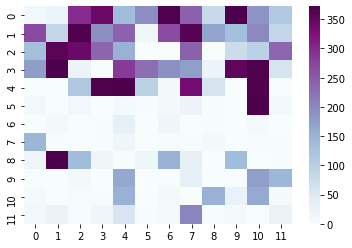

In [ ]:
attention = output['attentions']
attns = torch.stack([attn.squeeze(0) for attn in attention])

new_att = F.softmax(attns.float(), dim=-1)
new_att = F.softmax(new_att.float(),dim=-2)

new_att = torch.argmax(new_att, dim=-1)
new_att = torch.argmax(new_att, dim=-1)

sns.heatmap(new_att.detach().to('cpu').numpy(), cmap=plt.cm.BuPu)